In [23]:
import pandas as pd
import numpy as np
import datetime as dt
import time
from pathlib import Path
import os


from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import gc


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from itertools import product


import warnings
warnings.filterwarnings('ignore')

#### 1 Read parquet ####

In [2]:
# tripdata_2023_df

# Get the current working directory
cwd = Path(os.getcwd())
print("Current Path:", cwd)

os.chdir('../data')

# Define the path to the 'data' directory
# data_dir = cwd / 'data/parquet'

os.chdir('../data')
data_dir = Path(os.getcwd() +'/parquet/')

# Check if the path exists
if not data_dir.exists():
    print(f"The directory {data_dir} does not exist.")
    # return pd.DataFrame()  # Return an empty DataFrame if the directory doesn't exist

# 2023 trip data dataframe
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

df.head()

Current Path: c:\GIT\GitHub-Taxi\Dev2\nyc-taxi-fare-prediction\src


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,NaN
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,NaN
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,NaN
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,NaN
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,NaN


### 2 Perform cleanup ###

In [3]:
# df = tripdata_2023_df

start_time = time.time()  # Record the start time

# Maintaning data consistency for string data type
# Convert all object and category type columns to strings
for column in df.select_dtypes(include=['object', 'category']).columns:
    df[column] = df[column].astype(str)
print("Converting Columns Successfully")

# Combining similar columns (e.g., Airport Fee) and handling missing values
print("Combinining Columns")
if 'Airport_fee' in df.columns and 'airport_fee' in df.columns:
    df['Airport_fee'] = df['Airport_fee'].fillna(0)
    df['airport_fee'] = df['airport_fee'].fillna(0)
    df['Total_Airport_Fee'] = df['Airport_fee'] + df['airport_fee']
    df.drop(['Airport_fee', 'airport_fee'], axis=1, inplace=True)
print("Successfully Combined Columns")

print("Separating Numerical and Categorical Data")
# Separating numerical and categorical data
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Separation Complete")

# print("Starting Imputation for Numerical Columns")
# # Imputation for numerical columns
# knn_imputer = KNNImputer(n_neighbors=1)
# df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])
# print("Completed Imputation for Numerical Columns")

# print("Starting Imputation for Categhorical Columns")
# # Encoding categorical columns, imputation, and decoding
# if len(categorical_columns) > 0:
#     encoder = OrdinalEncoder()
#     # Fit and transform the data to encode
#     encoded_cats = encoder.fit_transform(df[categorical_columns].fillna('Missing'))
#     # Impute the encoded data
#     imputed_cats = knn_imputer.fit_transform(encoded_cats)
#     # Inverse transform to decode back to original categories
#     decoded_cats = encoder.inverse_transform(imputed_cats)
#     df[categorical_columns] = decoded_cats
# print("Completed Imputation for Categorical Columns")

# Check for null values post-imputation
print("\nNull values in each column:")
print(df.isnull().sum())

# Check number of records before removing duplicates
num_records_before = len(df)

# Remove duplicates
print("\nDuplicated rows:")
duplicated_rows = df[df.duplicated(keep=False)]
print(duplicated_rows)
df = df.drop_duplicates()

# Check number of records after removing duplicates
num_records_after = len(df)

print("\nRemoved duplicate rows.")
print("\nNumber of records before removing duplicates:", num_records_before)
print("Number of records after removing duplicates:", num_records_after)


# Data description
print("\nData Description:")
print(df.describe(include='all'))  # describe all columns

print(df.info())
print(df.head())

end_time = time.time()  # Record the end time
runtime = end_time - start_time  # Calculate the elapsed time
print("\nRuntime[perform_cleanup]:", runtime, "seconds\n")  # Print the runtime

df.to_csv("C:/dataset/cleaned_df.csv", index=False)



Converting Columns Successfully
Combinining Columns
Successfully Combined Columns
Separating Numerical and Categorical Data
Separation Complete

Null values in each column:
VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1309356
trip_distance                  0
RatecodeID               1309356
store_and_fwd_flag             0
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     1309356
Total_Airport_Fee              0
dtype: int64

Duplicated rows:
         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1413328         2  2023-11-13 13:26:12   2023-11-13 14:48:41              1.0   
1413329

#### 3 Handle Outlier ####

In [4]:
def data_scope(df):
    """
    Filters the DataFrame to include only payment types with values 1 and 2 and positive fare_amount.

    Parameters:
        df (DataFrame): The original DataFrame containing taxi fare data.

    Returns:
        DataFrame: Filtered DataFrame containing payment types 1 and 2 with positive fare_amount.

    Features Used:
        - fare_amount: Column representing the fare amount.
        - payment_type: Column representing the payment type.

    """
    fare = 'fare_amount'
    paytype = 'payment_type'

    # Filter DataFrame to include only payment types with values 1 and 2 and positive fare_amount
    scope_df = df[(df[paytype].isin([1, 2])) & (df[fare] > 0)]

    return scope_df



def handle_outliers(df):
    '''Handle outliers in a DataFrame column using the IQR method.
    
    Args:
    - df: DataFrame containing the data.

    Returns:
    - df_no_outliers: DataFrame with outliers removed.'''

    # Record the start time for runtime calculation.
    start_time = time.time()

    # Creating variable for the feature
    fare = 'fare_amount'

    # Get the data scope by filtering payment types 1 and 2 with positive fare amounts.
    scope_df = data_scope(df)

    # Count number of entries
    count = len(df)

    # Final count after filtering payment types and negative fare amounts
    final_count = len(scope_df)

    # Check how many entries where removed
    removed = count - final_count 

    # Print the count of entries before and after filtering.
    print('\nNumber entries', count)
    print('Payment Type 1 or 2 & Fare Amount greater than 0 :', final_count)
    print('Total entries removed', removed)

    # Print statistical details of fare_amount after filtering.
    data_desc = scope_df[fare].describe()
    print('\nStatistical Details:')
    print(data_desc)

    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = scope_df[fare].quantile(0.25)
    Q3 = scope_df[fare].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find maximum and minimum value
    max_value = scope_df[fare].max()
    min_value = scope_df[fare].min()

    # Print outlier boundaries and maximum/minimum values of fare_amount.
    print('\nLower Bound:', lower_bound)
    print('Upper Bound:', upper_bound)
    print("\nMaximum value in column '{}' is: {}".format(fare, max_value))
    print("Minimum value in column '{}' is: {}".format(fare, min_value))

    # Filter the DataFrame to remove outliers
    df_no_outliers = scope_df[(scope_df[fare] >= lower_bound) & (scope_df[fare] <= upper_bound)]

    # Print the number of records before and after removing outliers, and the number of outliers.
    print("\nNumber of records before removing outliers:", len(scope_df))
    print("Number of records after removing outliers:", len(df_no_outliers))
    print("Number of outliers", len(scope_df)-len(df_no_outliers))

    # Find maximum and minimum value
    max_value = df_no_outliers[fare].max()
    min_value = df_no_outliers[fare].min()

    print("\nAfter Removing Outliers:")

    # Get statistical details
    data_description = df_no_outliers[fare].describe()

    # Print or display the statistical information
    print('\nStatistical Information:')
    print(data_description)

    # Print maximum and minimum values of fare_amount after removing outliers.
    print("\nMaximum value in column '{}' is: {}".format(fare, max_value))
    print("Minimum value in column '{}' is: {}".format(fare, min_value))
    
    # Record the end time for runtime calculation and print the runtime.
    end_time = time.time()  # Record the end time
    runtime = end_time - start_time  # Calculate the elapsed time
    print("\nRuntime[handle_outliers]:", runtime, "seconds\n")  # Print the runtime

    return df_no_outliers


def extract_csv(df):
    # Created this method to extract sample dataset for data exploration
    # Get top 50 data from DataFrame
    top_50_data = df.head(50)
    # Specify the path where you want to save the CSV file
    csv_file_path = r"C:\Users\Administrator\OneDrive - Lambton College\Desktop\AI - Project\outliers.csv"

    # Save the top 50 data to a CSV file
    top_50_data.to_csv(csv_file_path, index=False)

    # print("Top 50 data extracted to CSV file:", csv_file_path)
    print("Top 50 data extracted to CSV file:", csv_file_path)
    

In [5]:

'''Handle outliers in a DataFrame column using the IQR method.
    
Args:
- df: DataFrame containing the data.

Returns:
- df_no_outliers: DataFrame with outliers removed.'''

# Record the start time for runtime calculation.
start_time = time.time()

# Creating variable for the feature
fare = 'fare_amount'

# Get the data scope by filtering payment types 1 and 2 with positive fare amounts.
scope_df = data_scope(df)

# Count number of entries
count = len(df)

# Final count after filtering payment types and negative fare amounts
final_count = len(scope_df)

# Check how many entries where removed
removed = count - final_count 

# Print the count of entries before and after filtering.
print('\nNumber entries', count)
print('Payment Type 1 or 2 & Fare Amount greater than 0 :', final_count)
print('Total entries removed', removed)

# Print statistical details of fare_amount after filtering.
data_desc = scope_df[fare].describe()
print('\nStatistical Details:')
print(data_desc)

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = scope_df[fare].quantile(0.25)
Q3 = scope_df[fare].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find maximum and minimum value
max_value = scope_df[fare].max()
min_value = scope_df[fare].min()

# Print outlier boundaries and maximum/minimum values of fare_amount.
print('\nLower Bound:', lower_bound)
print('Upper Bound:', upper_bound)
print("\nMaximum value in column '{}' is: {}".format(fare, max_value))
print("Minimum value in column '{}' is: {}".format(fare, min_value))

# Filter the DataFrame to remove outliers
df_no_outliers = scope_df[(scope_df[fare] >= lower_bound) & (scope_df[fare] <= upper_bound)]

# Print the number of records before and after removing outliers, and the number of outliers.
print("\nNumber of records before removing outliers:", len(scope_df))
print("Number of records after removing outliers:", len(df_no_outliers))
print("Number of outliers", len(scope_df)-len(df_no_outliers))

# Find maximum and minimum value
max_value = df_no_outliers[fare].max()
min_value = df_no_outliers[fare].min()

print("\nAfter Removing Outliers:")

# Get statistical details
data_description = df_no_outliers[fare].describe()

# Print or display the statistical information
print('\nStatistical Information:')
print(data_description)

# Print maximum and minimum values of fare_amount after removing outliers.
print("\nMaximum value in column '{}' is: {}".format(fare, max_value))
print("Minimum value in column '{}' is: {}".format(fare, min_value))

# Record the end time for runtime calculation and print the runtime.
end_time = time.time()  # Record the end time
runtime = end_time - start_time  # Calculate the elapsed time
print("\nRuntime[handle_outliers]:", runtime, "seconds\n")  # Print the runtime


df_no_outliers.to_csv("C:/dataset/df_no_outliers.csv", index=False)

df_no_outliers.head()






Number entries 38310224
Payment Type 1 or 2 & Fare Amount greater than 0 : 36165233
Total entries removed 2144991

Statistical Details:
count    3.616523e+07
mean     1.985007e+01
std      7.767031e+01
min      1.000000e-02
25%      9.300000e+00
50%      1.350000e+01
75%      2.190000e+01
max      3.869836e+05
Name: fare_amount, dtype: float64

Lower Bound: -9.599999999999998
Upper Bound: 40.8

Maximum value in column 'fare_amount' is: 386983.63
Minimum value in column 'fare_amount' is: 0.01

Number of records before removing outliers: 36165233
Number of records after removing outliers: 32365853
Number of outliers 3799380

After Removing Outliers:

Statistical Information:
count    3.236585e+07
mean     1.463720e+01
std      7.882277e+00
min      1.000000e-02
25%      8.600000e+00
50%      1.280000e+01
75%      1.840000e+01
max      4.080000e+01
Name: fare_amount, dtype: float64

Maximum value in column 'fare_amount' is: 40.8
Minimum value in column 'fare_amount' is: 0.01

Runtime[han

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Total_Airport_Fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


#### 4 Engineer New Features & Transformations #####

##### 5 Visualizations #####

In [6]:

# # Convert datetime columns to pandas datetime objects
# df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
# df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# # Calculate trip duration in minutes
# df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# # Created numerical_columns variable to contain features that has numerical values 
# numerical_columns = [
#     'passenger_count', 'trip_distance', 'fare_amount', 'extra',
#     'improvement_surcharge', 'tip_amount', 'tolls_amount', 'total_amount',
#     'congestion_surcharge', 'trip_duration', 'Total_Airport_Fee'
# ]

# # Plot histograms for each numerical column
# plt.figure(figsize=(15, 15))
# for index, column in enumerate(numerical_columns):
#     plt.subplot(4, 3, index + 1)
#     plt.hist(df[column], bins=10)
#     plt.grid(True)
#     plt.title(column)
#     plt.ylabel('Frequency')
#     plt.xlabel('Value')
# plt.tight_layout(pad=3.0)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)

# # Calculate and plot correlation heatmap
# filtered_df = df[numerical_columns]
# corr = filtered_df.corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
# plt.title('Correlation Heatmap')
# plt.show()

In [3]:
# df.to_csv("cleaned_df.csv", index=False)

df = pd.read_csv("C:/dataset/cleaned_df.csv")


#### Get the scope before remove outliers ####

In [5]:
"""
Filters the DataFrame to include only payment types with values 1 and 2 and positive fare_amount.

Parameters:
    df (DataFrame): The original DataFrame containing taxi fare data.

Returns:
    DataFrame: Filtered DataFrame containing payment types 1 and 2 with positive fare_amount.

Features Used:
    - fare_amount: Column representing the fare amount.
    - payment_type: Column representing the payment type.

"""
fare = 'fare_amount'
paytype = 'payment_type'

# Filter DataFrame to include only payment types with values 1 and 2 and positive fare_amount
scope_df = df[(df[paytype].isin([1, 2])) & (df[fare] > 0)]

scope_df.to_csv("C:/dataset/scope_df.csv", index=False);

scope_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Total_Airport_Fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [ ]:
del df

gc.collect()

#### Plotting boxplot of 'fare_amount' before and after handling outliers ####

In [3]:
df_no_outliers = pd.read_csv("C:/dataset/df_no_outliers.csv")


In [25]:
scope_df = pd.read_csv("C:/dataset/scope_df.csv")

MemoryError: Unable to allocate 2.43 GiB for an array with shape (9, 36165233) and data type float64

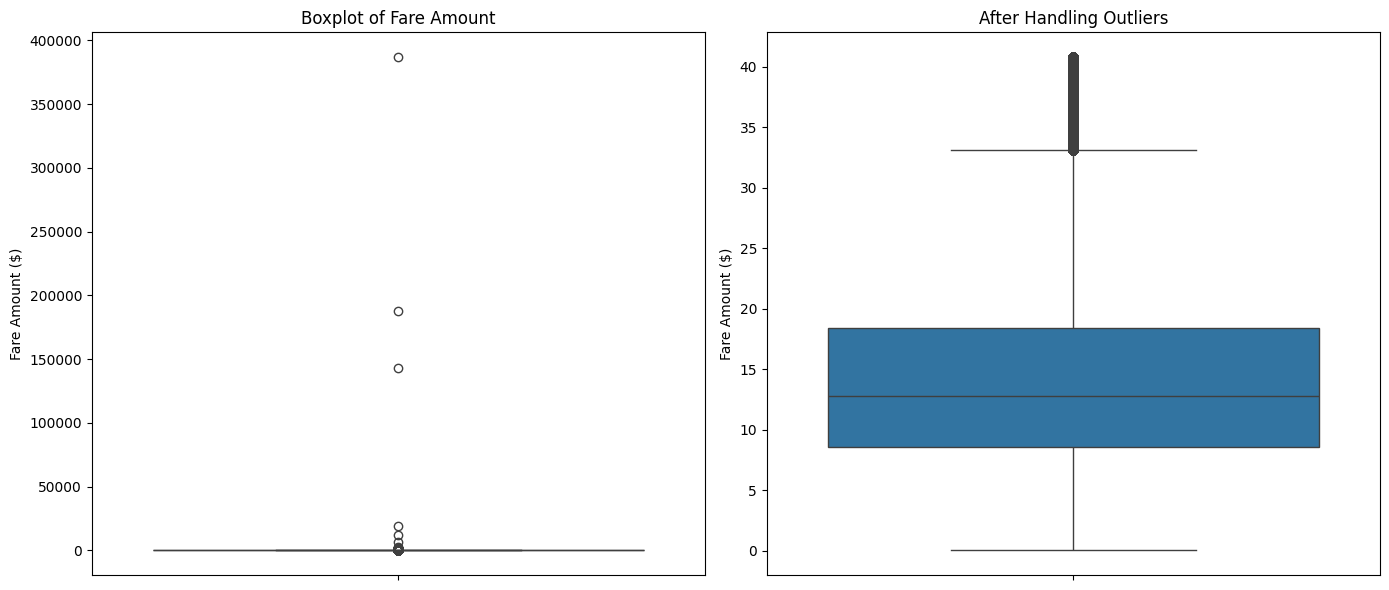


Runtime[handle_outliers]: 48.111273527145386 seconds



In [5]:
# df_no_outliers
# scope_df

"""
Generates boxplots of fare_amount before and after handling outliers.

Parameters:
    scope_df (DataFrame): DataFrame containing data before handling outliers.
    df_no_outliers (DataFrame): DataFrame containing data after handling outliers.

Returns:
    None

Plots:
    - Boxplot of 'fare_amount' before handling outliers.
    - Boxplot of 'fare_amount' after handling outliers.
    
"""
start_time = time.time()  # Record the start time

# Creating variables for the features 
fare = 'fare_amount'

# Plot boxplot of 'fare_amount' before handling outliers
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
sns.boxplot(y=scope_df[fare])
plt.title('Boxplot of Fare Amount')
plt.ylabel('Fare Amount ($)')

# Plot boxplot of 'fare_amount' after handling outliers
plt.subplot(1, 2, 2) 
sns.boxplot(y=df_no_outliers[fare])
plt.title('After Handling Outliers')
plt.ylabel('Fare Amount ($)')

# Show the plots
plt.tight_layout()
plt.show()

end_time = time.time()  # Record the end time
runtime = end_time - start_time  # Calculate the elapsed time
print("\nRuntime[handle_outliers]:", runtime, "seconds\n")  # Print the runtime

#### #6 Perform time series forecasting ####

In [24]:
# Record the start time for runtime calculation.
start_time = time.time()  # Record the start time

scope_df['day_of_week'] = scope_df['tpep_pickup_datetime'].dt.day_name()
scope_df['hour_of_day'] = scope_df['tpep_pickup_datetime'].dt.hour

# Group by day of the week and hour of the day, and count the number of trips
trips_per_hour_df = scope_df.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='num_trips')

# Create a complete datetime column based on the reference date
day_mapping = { 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7 }
trips_per_hour_df['day_of_week_numeric'] = trips_per_hour_df['day_of_week'].map(day_mapping)
reference_date = pd.Timestamp('2023-01-01')
trips_per_hour_df['datetime'] = reference_date + pd.to_timedelta(trips_per_hour_df['day_of_week_numeric'], unit='D') + pd.to_timedelta(trips_per_hour_df['hour_of_day'], unit='H')

# Sort the date accordingly then delete unused features
trips_per_hour_df.sort_values('datetime', inplace=True)

#print('trips_per_hour_df')
#print(trips_per_hour_df)
print('Saturday 11AM:', trips_per_hour_df[(trips_per_hour_df['day_of_week'] == 'Saturday') & (trips_per_hour_df['hour_of_day'] == 11)])

# Perform one-hot encoding
one_hot_encoded_days = pd.get_dummies(trips_per_hour_df['day_of_week'], prefix='day', drop_first=False)
one_hot_encoded_hours = pd.get_dummies(trips_per_hour_df['hour_of_day'], prefix='hour', drop_first=False)

# Concatenate the one-hot encoded days dataframe with the original DataFrame
trips_per_hour_df.reset_index(drop=True, inplace=True)
one_hot_encoded_days.reset_index(drop=True, inplace=True)
one_hot_encoded_days = one_hot_encoded_days.astype(int)
trips_per_hour_df = pd.concat([trips_per_hour_df, one_hot_encoded_days], axis=1)

# Concatenate the one-hot encoded hours dataframe with the original DataFrame
trips_per_hour_df.reset_index(drop=True, inplace=True)
one_hot_encoded_hours.reset_index(drop=True, inplace=True)
one_hot_encoded_hours = one_hot_encoded_hours.astype(int)
trips_per_hour_df = pd.concat([trips_per_hour_df, one_hot_encoded_hours], axis=1)

# Extract features and target variable
X = trips_per_hour_df[['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 
        'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_18', 'hour_20', 'hour_21', 'hour_22', 'hour_23',   
        'day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Friday', 'day_Saturday', 'day_Sunday']]
y = trips_per_hour_df['num_trips']

# Define the parameter grid for SARIMA model
p_values = range(0, 3)  # Range of AR terms
d_values = range(0, 2)  # Range of differences
q_values = range(0, 3)  # Range of MA terms
P_values = range(0, 3)  # Range of seasonal AR terms
D_values = range(0, 2)  # Range of seasonal differences
Q_values = range(0, 3)  # Range of seasonal MA terms
s_values = [24]  # Seasonal period (assuming hourly data)
# Generate all possible combinations of parameters
param_grid = product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values)

# Initialize variables to store best model and its performance
best_model = None
best_params = None
best_mse = float('inf')  # Initialize with a large value
best_rmse = float('inf')  # Initialize with a large value

# Initialize time series cross-validator
tscv = TimeSeriesSplit(n_splits=2)

# Perform grid search with cross-validation
for params in param_grid:
    try:
        mse_scores = []

        # Perform cross-validation
        for train_index, test_index in tscv.split(X):
            # Split the data into training and testing sets
            #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            print("Data type of y_train:", type(y_train))
            print("Data type of X_train_encoded:", type(X_train))

            print("Shape of y_train:", y_train.shape)
            print("Shape of X_train_encoded:", X_train.shape)

            # Define SARIMA parameters
            #order = (1, 1, 1)  # ARIMA order
            #seasonal_order = (1, 1, 1, 24)  # Seasonal order (24 hours in a day for daily seasonality)

            try:
                sarima_model = SARIMAX(y_train, exog=X_train, order=params[:3], seasonal_order=params[3:])
                #sarima_model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
                sarima_result = sarima_model.fit()
            except np.linalg.LinAlgError as e:
                print(f"Error encountered for order={params[:3]}, seasonal_order={params[3:]}: {e}")
                break

            # Make predictions
            predictions = sarima_result.predict(start=len(X_test), end=len(X_test)+len(X_test)-1, exog=X_test, dynamic=False)
            
            # Calculate MSE
            mse = mean_squared_error(y_test, predictions)
            print('mse:', mse)
            # Calculate root mean squared error (RMSE)
            rmse = np.sqrt(mse)
            print(rmse)
            mse_scores.append(mse)

        # Compute the average MSE across all folds
        if len(mse_scores) > 0 :
            average_mse = sum(mse_scores) / len(mse_scores)
            print("Average Mean Squared Error (Cross-Validation):", average_mse)
            print("Average Root Mean Squared Error (Cross-Validation):", np.sqrt(average_mse))

            # Update best model if current model has lower MSE
            #'''
            if average_mse < best_mse:
                best_mse = average_mse
                best_rmse = np.sqrt(best_mse)
                best_params = params
                best_model = SARIMAX(y, exog=X, order=best_params[:3], seasonal_order=best_params[3:])
                sarima_result = best_model.fit()  # Fit the best model using the entire dataset
            #'''
    except:
        continue

# Print the best model parameters and MSE
print("Best SARIMA Model:")
print("Order:", best_params[:3])
print("Seasonal Order:", best_params[3:])
print("Best MSE:", best_mse) 
print("Best RMSE:", best_rmse)

end_time = time.time()  # Record the end time
runtime = end_time - start_time  # Calculate the elapsed time
print("Runtime[Tme Series]:", runtime, "seconds\n")  # Print the runtime

print(sarima_result)

sarima_result.save("C:/dataset/timeseries2.pkl")

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
sarima_result.save("C:/dataset/timeseries2.pkl")

In [ ]:
# !dir

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# sarima_result2 = SARIMAXResults.load("timeseries.pkl")

In [ ]:
# sarima_result2

In [8]:
def run_example_forecast(day_of_week, hour_of_day, time_series_model):
   
    exog_df = generate_exog(day_of_week, hour_of_day)

    # Call the forecast function of the SARIMAX model
    forecast = time_series_model.forecast(steps=1, exog=exog_df)
    print(f"Forecasted value is: {forecast}")
    return forecast

# Function to generate the exogenous variables DataFrame dynamically
def generate_exog(day_of_week, hour_of_day):
    # Create empty DataFrame with all zeros
    exog_data = {
        'day_Monday': [0],
        'day_Tuesday': [0],
        'day_Wednesday': [0],
        'day_Thursday': [0],
        'day_Friday': [0],
        'day_Saturday': [0],
        'day_Sunday': [0],
        'hour_0': [0],
        'hour_1': [0],
        'hour_2': [0],
        'hour_3': [0],
        'hour_4': [0],
        'hour_5': [0],
        'hour_6': [0],
        'hour_7': [0],
        'hour_8': [0],
        'hour_9': [0],
        'hour_10': [0],
        'hour_11': [0],
        'hour_12': [0],
        'hour_13': [0],
        'hour_14': [0],
        'hour_15': [0],
        'hour_16': [0],
        'hour_17': [0],
        'hour_18': [0],
        'hour_19': [0],
        'hour_20': [0],
        'hour_21': [0],
        'hour_22': [0],
        'hour_23': [0],
    }
    
    # Set the corresponding day and hour to 1
    exog_data[f'day_{day_of_week}'] = [1]
    exog_data[f'hour_{hour_of_day}'] = [1]
    
    # Create DataFrame with exogenous variables
    exog_df = pd.DataFrame(exog_data)
    return exog_df

In [ ]:
sample_prediction = run_example_forecast('Saturday', 11, sarima_result)
print('sample prediction >>>> ', sample_prediction)

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

sarima_result2 = SARIMAXResults.load("C:/dataset/timeseries.pkl")

In [14]:
sample_prediction2 = run_example_forecast('Saturday', 11, sarima_result2)
print('sample prediction >>>> ', sample_prediction2)

Forecasted value is: 168    25453.397319
dtype: float64
sample prediction >>>>  168    25453.397319
dtype: float64


In [16]:
sample_prediction2 = run_example_forecast('Sunday', 11, sarima_result2)
print('sample prediction >>>> ', sample_prediction2)

Forecasted value is: 168    25453.397319
dtype: float64
sample prediction >>>>  168    25453.397319
dtype: float64


In [18]:
sample_prediction2 = run_example_forecast('Monday', 11, sarima_result2)
print('sample prediction >>>> ', sample_prediction2)

Forecasted value is: 168    25453.397319
dtype: float64
sample prediction >>>>  168    25453.397319
dtype: float64


In [19]:
sample_prediction2 = run_example_forecast('Saturday', 16, sarima_result2)
print('sample prediction >>>> ', sample_prediction2)

Forecasted value is: 168    25453.39732
dtype: float64
sample prediction >>>>  168    25453.39732
dtype: float64


In [20]:
sample_prediction2 = run_example_forecast('Sunday', 16, sarima_result2)
print('sample prediction >>>> ', sample_prediction2)

Forecasted value is: 168    25453.39732
dtype: float64
sample prediction >>>>  168    25453.39732
dtype: float64


In [21]:
sample_prediction2 = run_example_forecast('Thursday', 6, sarima_result2)
print('sample prediction >>>> ', sample_prediction2)

Forecasted value is: 168    25453.39732
dtype: float64
sample prediction >>>>  168    25453.39732
dtype: float64
